# Deteção de Fraude em Transações Ethereum

## Business Understanding

O objetivo deste projeto é desenvolver um modelo ML para detetar fraudes em transações Ethereum. A blockchain Ethereum processa milhares de transações diariamente, pelo que identificar transações fraudulentas em tempo real se torna um problema e um desafio significativo para a segurança da rede que precisa de ser resolvido.

### Objetivos
- **Identificar padrões de transações fraudulentas** no Ethereum para sinalizar atividades suspeitas.
- **Minimizar falsos positivos e falsos negativos**, já que transações legítimas classificadas como fraudulentas pode ter implicações/atritos, e fraudes classificadas incorretamente como legítimas podem causar perdas financeiras e vulnerabilidades do sistema.

### Métricas a ter em conta
1. **Precisão do Modelo**: precisão, recall, F1-score, AUC, etc. 
2. **Eficiência**: tempo de execução, recursos computacionais, etc.
3. **Viabilidade Operacional**: facilidade de implementação, interpretabilidade, aplicabilidade prática em tempo real, etc.

### Avaliação de Risco
- **Qualidade dos Dados**: dados de transações Ethereum são altamente voláteis e complexos, com muitos fatores a considerar. Podem conter erros, valores inconsistentes, valores em falta, etc.
- **Regulamentação**: a deteção de fraudes em transações Ethereum pode estar sujeita a regulamentações e leis de privacidade de dados.
- **Impacto Financeiro**: qual será o impacto financeiro de falsos positivos e falsos negativos? Como podemos minimizar esses impactos?

## Data Understanding
Para entender os dados, vamos carregar o dataset e explorar as suas características.

### Estrutura do Dataset
O dataset tem as seguintes colunas:
- `TxHash`: Id exclusivo de cada transação.
- `BlockHeight`: número do bloco onde a transação foi incluída.
- `TimeStamp`: data e hora da transação.
- `From`: endereço Ethereum do remetente.
- `To`: endereço Ethereum do destinatário.
- `Value`: quantidade de Ether transferida.
- `isError`: indicador de erro na transação (0 = sem erro, 1 = com erro).



In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar opções de visualização
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [41]:
fo_df = pd.read_csv('dataset/first_order_df.csv')
fo_df.head()

,Unnamed: 0,TxHash,BlockHeight,TimeStamp,From,To,Value,isError
0,0,0xaca3850ba0080cf47b47f80e46da452f61bcbb5470d3...,5848095,1529873859,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000,0
1,1,0x95681862f9778e49caecf603dd911d6ed57f7799d89d...,5848181,1529875104,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020,0
2,2,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716,1529883192,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390,0
3,3,0xf397197b800d6cc055a4db265b5e9df3dd2aa745c813...,5849038,1529887684,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800,0
4,4,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437,1529893144,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506,0


In [42]:
fo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254973 entries, 0 to 254972
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   254973 non-null  int64  
 1   TxHash       254973 non-null  object 
 2   BlockHeight  254973 non-null  int64  
 3   TimeStamp    254973 non-null  int64  
 4   From         254973 non-null  object 
 5   To           254642 non-null  object 
 6   Value        254973 non-null  float64
 7   isError      254973 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 15.6+ MB


Ao verificar informações gerais do dataset, percebe-se que existe uma coluna `Unnamed: 0` que não possui informações relevantes para a análise. Portanto, será removida.

In [43]:
fo_df.drop(['Unnamed: 0'], axis=1, inplace=True)
fo_df

,TxHash,BlockHeight,TimeStamp,From,To,Value,isError
0,0xaca3850ba0080cf47b47f80e46da452f61bcbb5470d3...,5848095,1529873859,0x16f209b5332a1b4fa5bf19497ca40154c5db2f85,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.500000,0
1,0x95681862f9778e49caecf603dd911d6ed57f7799d89d...,5848181,1529875104,0xe7e07e44ee315b5f2d076340b2b7a5cc9a4ee57b,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.001020,0
2,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716,1529883192,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390,0
3,0xf397197b800d6cc055a4db265b5e9df3dd2aa745c813...,5849038,1529887684,0x0681d8db095565fe8a346fa0277bffde9c0edbbf,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0.817800,0
4,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437,1529893144,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506,0
...,...,...,...,...,...,...,...
254968,0xefbdb95e7e0dae4f83f975a44c7ccf7e6b027131969e...,6101678,1533603040,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x725d0607775d6e8e85136e51808b9492e39d217d,0.700000,0
254969,0x37c0af73723405236804486c835282a1971e08a45a11...,6104069,1533638323,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x5d63c7b81aaa63d2df376c0bc6197ab5132e94e7,0.770000,0
254970,0xdd193f8d9ebf7eecd3ad59192a807b420e3a5d38ff1a...,6104111,1533639008,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x1219320139334c3d79aae0507a2aa9e278935665,0.500000,0
254971,0x1b3329bdb6c8d6a817ebe55bfd6434ece5cb23817b0d...,6104810,1533649370,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0xf3702667fb827bd9c675b88187e9a764b5dc9d40,0.330000,0


Há dados nulos? Há dados duplicados? Qual é a distribuição dos dados?

In [44]:
print(fo_df.isnull().sum())

fo_df.describe()

TxHash           0
BlockHeight      0
TimeStamp        0
From             0
To             331
Value            0
isError          0
dtype: int64


,BlockHeight,TimeStamp,Value,isError
count,2.549730e+05,2.549730e+05,254973.000000,254973.000000
mean,5.391963e+06,1.522941e+09,4.784175,0.061316
std,7.332419e+05,1.107530e+07,207.403848,0.239910
min,2.722620e+06,1.480521e+09,0.000000,0.000000
25%,4.908133e+06,1.515950e+09,0.000000,0.000000
50%,5.356399e+06,1.522521e+09,0.012500,0.000000
75%,5.855385e+06,1.529985e+09,0.500000,0.000000
max,7.781130e+06,1.558142e+09,25533.614518,1.000000


Há 254,973 entradas no dataset. Algumas coisas a destacar:
- A coluna `To` tem 331 valores nulos. Vamos verificar.
- O valor médio das transações é de 4,78 Ethereum.
- A transação mais cara foi de 25533 Ethereum.
- Existem transações com o valor de 0 Ethereum.

In [45]:

count_isError = 0
count_notIsError = 0

for index, row in fo_df[fo_df['To'].isnull()].iterrows():
    if row['isError'] == 1:
        count_isError += 1
    else:
        count_notIsError += 1

print('isError:', count_isError)
print('notIsError:', count_notIsError)
    

isError: 3
notIsError: 328


Dos 331 valores nulos, apenas 3 são de erro, pelo que provavelmente não teremos problemas em remover esses valores. Além de representarem apenas uma pequeníssima percentagem do número total de dados, parece que não há grande relação entre o facto de a coluna `To` estar nula e a coluna `isError` ser 1.

In [46]:
filtered_fo_df = fo_df.dropna(subset=['To'])

### Análise da variável `isError`
A variável `isError` é o alvo da nossa análise, onde `0` indica que a transação foi realizada sem erro e `1` indica um erro (possivelmente fraude). Vamos examinar a distribuição dessa variável.

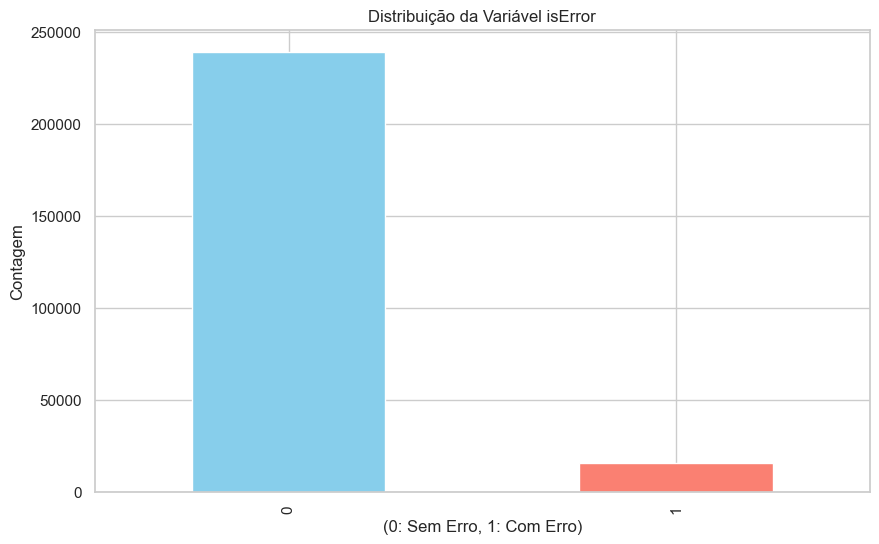

isError
0    93.861578
1     6.138422
Name: proportion, dtype: float64

In [47]:
filtered_fo_df['isError'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição da Variável isError')
plt.xlabel('(0: Sem Erro, 1: Com Erro)')
plt.ylabel('Contagem')
plt.show()


filtered_fo_df['isError'].value_counts(normalize=True) * 100

A target variable `isError` é desbalanceada, com 93,86% das transações sem erro e 6,1% com erro.

### Análise da Variável `Value`
A variável `Value`, que representa a quantidade de Ether transferida, pode ser um indicativo de transações suspeitas.

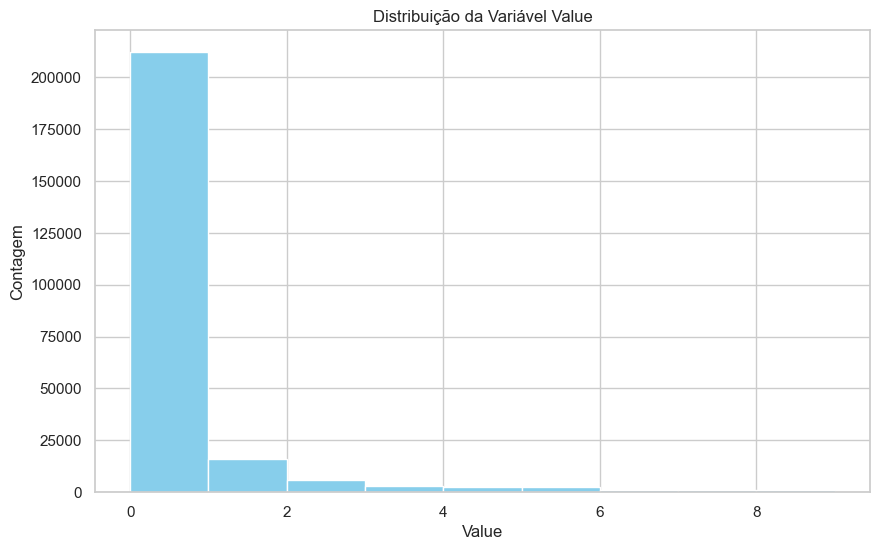

In [48]:
# Distribuição da variável Value, com steps de 1 no eixo x
filtered_fo_df['Value'].plot(kind='hist', bins=range(0, 10, 1), color='skyblue')
plt.title('Distribuição da Variável Value')
plt.xlabel('Value')
plt.ylabel('Contagem')
plt.show()

Consegue-se ver que há muitas entradas cujo valor transacionado é 0. No contexto de transações em Ethereum, é possível que representem:
- Transações de contrato inteligente (smart contract) que não envolvem transferência de Ether, tipo NFTs, DeFi.
- Transações de teste.
- Transações fraudulentas.

Pode-se verificar a coluna `isError` nas transações com valor 0 para ver se há alguma relação.

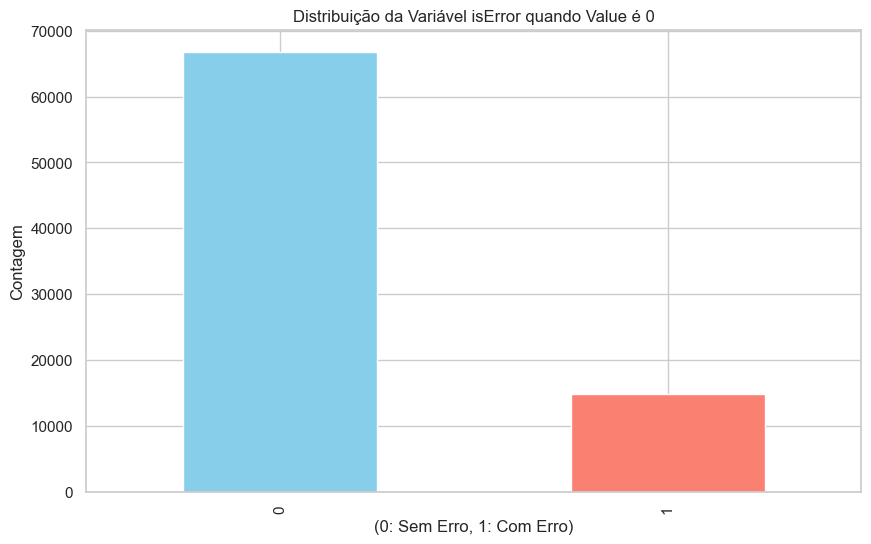

In [49]:
# print when value is 0
trans_value_0 = filtered_fo_df[filtered_fo_df['Value'] == 0]

trans_value_0.head()

trans_value_0['isError'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribuição da Variável isError quando Value é 0')
plt.xlabel('(0: Sem Erro, 1: Com Erro)')
plt.ylabel('Contagem') 
plt.show()


### Correlação entre as variáveis

Normalmente, faria a correlação entre variáveis para analisar se existe relação entre as variáveis e a variável alvo. No entanto, tirando as variáveis categóricas, ficariamos apenas com as variáveis `Value`, `BlockHeight` e `Timestamp`. Pelo contexto em questão, provavelmente a matriz de correlaçao não seria muito útil, mas vamos verificar.

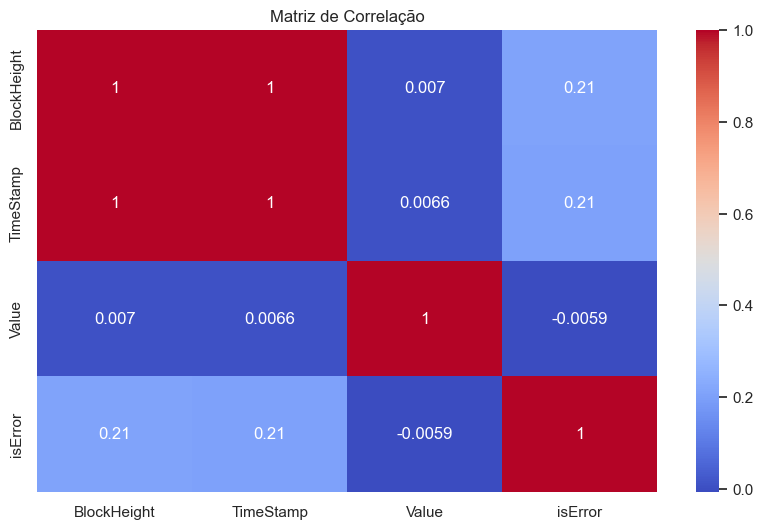

In [50]:
df_numeric = filtered_fo_df.select_dtypes(include=['float64', 'int64'])

correlation = df_numeric.corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

`BlockHeight` e `Timestamp` estão diretamente relacionadas entre si, o que é natural pois a blockchain é uma sequência de blocos, e cada bloco é adicionado à blockchain num intervalo de tempo.

Agora, para otimizar a análise e melhorar a qualidade dos dados, aplicamos um filtro que limita os endereços considerados no conjunto de dados. Este processo de filtragem visa incluir apenas contas com uma atividade significativa, definida como aquelas que têm entre 4 e 500 transações. Esta abordagem traz várias vantagens:

1. **Foco em Contas Ativas**:
   - Endereços com menos de 5 transações são mais inativos, representando atividade mínimak, podendo introduzir ruído nos dados. Por outro lado, endereços com mais de 500 transações costumam ser exchanges ou contratos inteligentes muito populares, que podem não ser relevantes para análises de fraude direcionadas a contas de menor visibilidade.

2. **Melhoria de Desempenho Computacional**:
   - Em datasets grandes, limitar o número de contas a analisar é essencial para manter o tempo de execução e o uso de memória dentro de parâmetros razoáveis, especialmente ao criar grafos de relação entre carteiras.

3. **Potencial Detecção de Fraudes em Padrões Menos Óbvios**:
   - Contas com atividade moderada, mas consistente, são mais propensas a padrões de fraude discreta, enquanto contas altamente ativas geralmente estão mais expostas e são de entidades conhecidas.

In [51]:
# Obter contagens totais de transações para cada endereço
from_counts = filtered_fo_df['From'].value_counts()
to_counts = filtered_fo_df['To'].value_counts()

# Somar as contagens de 'From' e 'To' para obter uma contagem combinada
combined_counts = from_counts.add(to_counts, fill_value=0)

# Filtrar endereços com transações entre 5 e 500
filtered_counts = combined_counts.loc[(combined_counts >= 5) & (combined_counts <= 500)]

# Selecionar apenas transações que envolvem os endereços filtrados
values_to_keep = filtered_counts.index.tolist()
filtered_df = filtered_fo_df[filtered_fo_df['From'].isin(values_to_keep) & filtered_fo_df['To'].isin(values_to_keep)]

# Resetar o índice do DataFrame filtrado
filtered_df = filtered_df.reset_index(drop=True)
filtered_df


,TxHash,BlockHeight,TimeStamp,From,To,Value,isError
0,0x716ae3961b50186a0bbc272cfcc4555662f7fe33550f...,5848716,1529883192,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.500390,0
1,0x7f8086011a32f128dba57fe06fc5f4a181d2f5401e5a...,5849437,1529893144,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0.817506,0
2,0xb8a7330af45b7be8155e4ffe437110ce912cb7986632...,4981935,1517057137,0xcbb240ad8beb648773d78d966caaee46d45add3a,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0.002305,0
3,0xd3e26b0a15a76c1fda5ee297924c7a46b75811588fb3...,4982190,1517060992,0xc90873d0c4b07db2327676d3b3f2add807d5fc0e,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0.014261,0
4,0xf1df92e16295368daf93e3cf793359f6ba8ef2d3e2e5...,4982642,1517067252,0xfffa5f2b2cb0b916ef69cc23cacf02f34abd0a79,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,0.008121,0
...,...,...,...,...,...,...,...
43537,0x020f75601c9fc8a5029a65c492e5753cda3a3a20efdc...,6064839,1533065124,0x2a4127e646f0ec5d39d604d9085a88296049d337,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0.068800,0
43538,0x6da824b9a5b3e5f1e416a4a5f58cec67375e89d21e88...,6064851,1533065246,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x2a4127e646f0ec5d39d604d9085a88296049d337,0.229000,0
43539,0x40dfa46e27534c52c174e3f2c503677d546ce03b6406...,6064861,1533065387,0x2a4127e646f0ec5d39d604d9085a88296049d337,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0.228910,0
43540,0xbd0352624b75713beaa77116e5ac1271b44f87d70d46...,6064872,1533065544,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,0x2a4127e646f0ec5d39d604d9085a88296049d337,0.025000,0


## Node Embeddings

Para detetar fraudes em transações Ethereum, vamos usar Node Embeddings para representar os endereços Ethereum como vetores densos. Esses vetores densos capturam as relações e padrões entre os endereços, permitindo-nos detetar anomalias e transações fraudulentas com base nas suas representações vetoriais.

### Node2Vec

Node2Vec é um algoritmo de aprendizagem de representação de grafos que mapeia nós de um grafo para vetores densos. Ele captura a estrutura e a topologia do grafo, permitindo-nos representar endereços Ethereum como vetores densos que capturam as relações entre eles. Vamos aplicar o algoritmo Node2Vec ao grafo de transações Ethereum para obter representações vetoriais dos endereços Ethereum. 

In [ ]:
import random
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F

# Semente global para os módulos que geram aleatoriedade
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Para manter o determinismo no uso de GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Criação de um grafo direcionado
graph = nx.DiGraph()

# Adicionar nós ao grafo
for i in range(len(filtered_df)):
  graph.add_edge(filtered_df['From'][i],filtered_df['To'][i])

In [ ]:
from node2vec import Node2Vec

# Parâmetros de configuração para o Node2Vec
walk_length = 20   # Comprimento de cada passeio
num_walks = 100    # Número de passeios por nó
p = 0.5           # Parâmetro de retorno
q = 2.0          # Parâmetro de avanço para controle BFS/DFS

# Cria o modelo Node2Vec no grafo
node2vec = Node2Vec(graph, dimensions=64, walk_length=walk_length, num_walks=num_walks, p=p, q=q, workers=4)
# Treina o modelo Word2Vec baseado nas walks geradas
model = node2vec.fit(window=4, min_count=1, batch_words=4)

# Verifique as representações dos nós
node_embeddings = model.wv

Computing transition probabilities:   0%|          | 0/4870 [00:00<?, ?it/s]

## Feature Engineering

Com as representações vetoriais dos endereços Ethereum, podemos criar features adicionais para detetar fraudes em transações Ethereum. Algumas features que podemos criar incluem:

1. **Total Degree (Grau Total)**
   - O grau total de um nó representa o número total de conexões (arestas) com outros nós, independentemente de serem transações de entrada ou saída.
   - **Importância:** Um nó com um grau total elevado pode ser considerado altamente interativo, indicando que ele está envolvido em muitas transações. Esse tipo de nó pode representar uma conta central ou muito ativa dentro da rede. Um grau total anormalmente alto pode também ser um indicativo de manipulação ou atividade suspeita.

2. **Out-Degree (Grau de Saída)**
   - O grau de saída se refere ao número de transações enviadas por um nó para outros nós.
   - **Importância:** Esse valor é importante para identificar nós que estão dispersando ativos. Se um nó tem um grau de saída muito alto, isso pode sugerir tentativas de dispersar os valores para ocultar sua origem ou, em contextos fraudulentos, para realizar lavagem de dinheiro.

3. **In-Degree (Grau de Entrada)**
   - O grau de entrada mede o número de transações recebidas por um nó de outros nós.
   - **Importância:** Um grau de entrada elevado pode indicar que o nó está acumulando grandes quantidades de recursos. Isso pode ser característico de nós que recebem muitos depósitos ou transferências, mas que não realizam muitas transações em troca, o que pode ser um comportamento suspeito.

4. **Out-Degree Ratio (Rácio de Grau de Saída)**
   - O rácio de grau de saída é a razão entre o grau de saída e o grau de entrada de um nó.
   - **Importância:** Esse rácio pode indicar o comportamento de dispersão de um nó. Se o valor for alto, pode significar que o nó está enviando grandes quantidades de recursos, o que pode ser característico de tentativas de dispersar recursos ou ocultar a origem dos mesmos.

5. **In-Degree Ratio (Rácio de Grau de Entrada)**
   - O rácio de grau de entrada é a razão entre o grau de entrada e o grau de saída de um nó.
   - **Importância:** Esse valor pode revelar a tendência de um nó em ser mais receptor do que emissor de transações. Um rácio elevado pode indicar que o nó está acumulando recursos e pode ser um comportamento típico de nós envolvidos em fraudes ou lavagem de dinheiro, que buscam acumular ativos sem dispersá-los.

6. **Sum of Transactions (Soma das Transações)**
   - A soma das transações é o valor total transacionado por um nó, incluindo tanto transações de entrada quanto de saída.
   - **Importância:** A soma total das transações é um bom indicador da quantidade de valor envolvido com o nó. Se um nó movimenta grandes quantidades de ativos, isso pode ser um indicativo de sua relevância na rede, mas também de atividade fraudulenta, caso o volume de transações não corresponda à atividade normal esperada.

7. **Transfer-Out Transaction (Transação de Saída)**
   - A transação de saída é a soma dos valores das transações enviadas pelo nó.
   - **Importância:** Esse valor é relevante para identificar nós que estão enviando grandes quantidades de recursos para outros nós. Esse comportamento pode ser um sinal de dispersão de ativos para outras contas, o que pode ser um padrão típico de lavagem de dinheiro.

8. **Transfer-In Transaction (Transação de Entrada)**
   - A transação de entrada representa a soma dos valores recebidos por um nó de outros nós.
   - **Importância:** A quantidade de transações de entrada ajuda a entender o papel do nó na rede, seja como receptor de recursos ou como acumulador de ativos. Um número alto de transações de entrada pode indicar um comportamento suspeito se não houver uma correspondência com transações de saída, sugerindo que o nó pode ser utilizado para acumular recursos de forma anormal.

9. **Transaction Difference (Diferença de Transações)**
   - A diferença de transações é a diferença entre a soma das transações de entrada e saída de um nó.
   - **Importância:** Esse valor revela se um nó é um "acumulador" (mais entradas do que saídas) ou um "dispersor" (mais saídas do que entradas). Uma diferença positiva pode indicar um nó acumulando recursos, enquanto uma diferença negativa pode sugerir que o nó está enviando grandes quantidades de ativos.

10. **Transaction Ratio (Rácio de Transações)**
    - O rácio de transações é a razão entre as transações de entrada e saída de um nó.
    - **Importância:** Esse rácio pode ajudar a entender o equilíbrio entre as transações de entrada e saída de um nó. Se um nó tem um rácio muito alto, isso pode indicar que ele está mais focado em receber recursos do que em enviar, o que pode ser um comportamento anômalo dependendo do contexto.

11. **Transfer-In Ratio (Rácio de Entrada)**
    - O rácio de entrada é a razão entre as transações de entrada e o grau de entrada de um nó.
    - **Importância:** Esse valor pode indicar se o nó está recebendo mais recursos do que seria esperado com base na sua interação com outros nós. Isso pode sugerir que o nó está acumulando recursos de forma incomum, o que é um comportamento que merece atenção, especialmente em análises de fraudes.

12. **Transfer-Out Ratio (Rácio de Saída)**
    - O rácio de saída é a razão entre as transações de saída e o grau de saída de um nó.
    - **Importância:** Esse rácio pode revelar se o nó está tentando enviar recursos de forma mais ativa em comparação ao seu grau de interação com outros nós. Esse comportamento pode ser uma forma de dispersar valores rapidamente, uma prática comum em atividades fraudulentas.

13. **Number of Neighbours (Número de Vizinhos)**
    - O número de vizinhos representa a quantidade de nós diretamente conectados ao nó em questão.
    - **Importância:** Esse valor é importante para entender a centralidade de um nó dentro da rede. Nós com muitos vizinhos podem ser considerados nós centrais e essenciais, enquanto nós com poucos vizinhos podem ser menos relevantes. A quantidade de vizinhos também pode ajudar a identificar padrões de agrupamento ou isolamento dentro da rede.

14. **Inverse Timestamp Frequency (Frequência Inversa do Timestamp)**
    - A frequência inversa do timestamp calcula a frequência média das transações de um nó com base na diferença entre os timestamps das transações.
    - **Importância:** Uma frequência alta de transações (ou uma diferença de tempo pequena entre elas) pode indicar um nó com atividades suspeitas ou um padrão anômalo de comportamento, como tentativas de mover grandes quantidades de recursos rapidamente.


In [54]:
from tqdm import tqdm

# calcula graus de entrada e saída para cada nó
degrees = graph.degree()
in_degrees = graph.in_degree()
out_degrees = graph.out_degree()

data = []
nodes = graph.nodes()

# print de informações para cada nó
for node in tqdm(list(nodes)):
    degree = degrees[node]
    in_degree = in_degrees[node]
    out_degree = out_degrees[node]
    in_degree_ratio = in_degree / out_degree if out_degree != 0 else float('inf')
    out_degree_ratio = out_degree / in_degree if in_degree != 0 else float('inf')
    transfer_out = filtered_df.loc[filtered_df['From'] == node, 'Value'].sum()
    transfer_in = filtered_df.loc[filtered_df['To'] == node, 'Value'].sum()
    transaction = transfer_out+transfer_in
    transaction_diff = transfer_in-transfer_out
    transaction_ratio = transfer_in / transfer_out if transfer_out != 0 else float('inf')
    transfer_in_ratio = transfer_in / in_degree if in_degree != 0 else float('inf')
    transfer_out_ratio = transfer_out / out_degree if out_degree != 0 else float('inf')
    neighbours = len(set(graph.neighbors(node)))

    timestamp_diff = ((filtered_df.loc[filtered_df['From'] == node, 'TimeStamp'].diff()).sum() + (filtered_df.loc[filtered_df['To'] == node, 'TimeStamp'].diff()).sum())
    avg_timestamp_diff = timestamp_diff/(len(filtered_df.loc[filtered_df['From'] == node, 'TimeStamp'])+len(filtered_df.loc[filtered_df['To'] == node, 'TimeStamp']))
    inv_timestamp_freq = 1/avg_timestamp_diff

    node_dict = {"Node": node,
                 "Total Degree": degree,
                 "Out-Degree": out_degree,
                 "In-Degree": in_degree,
                 "Out-Degree Ratio": out_degree_ratio,
                 "In-Degree Ratio": in_degree_ratio,
                 "Sum of Transactions": transaction,
                 "Transfer-Out Transaction": transfer_out,
                 "Transfer-In Transaction": transfer_in,
                 "Transaction Difference": transaction_diff,
                 "Transaction_Ratio": transaction_ratio,
                 "Transfer-In Ratio": transfer_in_ratio,
                 "Transfer-Out Ratio": transfer_out_ratio,
                 "Number of Neighbours": neighbours,
                 "Inverse Timestamp Frequency": inv_timestamp_freq
                 }
    data.append(node_dict)

  0%|          | 4/4870 [00:00<02:06, 38.49it/s]C:\Users\maysa\AppData\Local\Temp\ipykernel_25292\1980365642.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  inv_timestamp_freq = 1/avg_timestamp_diff
100%|██████████| 4870/4870 [01:38<00:00, 49.63it/s]


## Temporal Graph Attention Layer

In [55]:
timestamp_nodes = []
for i in tqdm(range(len(data))):
  fr = list(filtered_df[filtered_df['From']==data[i]['Node']]['TimeStamp'])
  to = list(filtered_df[filtered_df['To']==data[i]['Node']]['TimeStamp'])
  fr = fr+to
  timestamp_nodes.append(fr)

100%|██████████| 4870/4870 [00:32<00:00, 151.16it/s]


In [56]:
nodes = [
    [node['Total Degree'], node['Out-Degree'], node['In-Degree'],
     node['Out-Degree Ratio'], node['In-Degree Ratio'], node['Sum of Transactions'],
     node['Transfer-Out Transaction'], node['Transfer-In Transaction'],
     node['Transaction Difference'], node['Transaction_Ratio'],
     node['Transfer-In Ratio'], node['Transfer-Out Ratio'],
     node['Number of Neighbours'], node['Inverse Timestamp Frequency']]
    for node in data
]

edges = [
    [ node['Out-Degree'], node['In-Degree'],
     node['Out-Degree Ratio'], node['In-Degree Ratio'],
     node['Transfer-Out Transaction'], node['Transfer-In Transaction'],
     node['Transfer-In Ratio'], node['Transfer-Out Ratio']]
    for node in data
]

In [57]:
import gc
gc.collect()

# define a camada TGAT (Temporal Graph Attention Layer)
class TGATLayer(nn.Module):
    def __init__(self, input_dim, edge_dim, hidden_dim, num_heads):
        super(TGATLayer, self).__init__()
        self.num_heads = num_heads
        # projeções lineares para 'query', 'key', and 'value' na atenção
        self.Wq = nn.Linear(input_dim + edge_dim, hidden_dim * num_heads)
        self.Wk = nn.Linear(input_dim + edge_dim, hidden_dim * num_heads)
        self.Wv = nn.Linear(input_dim + edge_dim, hidden_dim * num_heads)

        # projeção linear para saída
        self.Wout = nn.Linear(hidden_dim, hidden_dim * num_heads)
        if (self.Wout).in_features == 1: # ajusta a projeção caso o hidden_dim seja pequeno
          self.Wout = nn.Linear(hidden_dim * num_heads, hidden_dim)

    # método de propagação da camada TGAT
    def forward(self, node_features, edge_features, timestamps_list, num_nodes):
        # concatena as features dos nós e das arestas
        Z = torch.cat([node_features, edge_features], dim=1)
        
        # aplica projeções lineares para gerar queries, keys e values
        Q = self.Wq(Z).view(-1, num_nodes, hidden_dim)
        K = self.Wk(Z).view(-1, num_nodes, hidden_dim)
        V = self.Wv(Z).view(-1, num_nodes, hidden_dim)

        # Concatena os timestamps ao longo de uma nova dimensão
        timestamps_tensor = torch.stack(timestamps_list, dim=1)

        # calcula scores de atenção, normalizando pela raiz quadrada da dimensão
        attention_scores = torch.matmul(Q, K.transpose(1, 2)) / torch.sqrt(torch.tensor(hidden_dim, dtype=torch.float32))
        
        # normaliza os scores para obter pesos de atenção
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = torch.nan_to_num(attention_weights, nan=0) # Lida com valores nulos
        V = torch.nan_to_num(V, nan=0) # Lida com valores NaN
        attended_values = torch.matmul(attention_weights, V)
        attended_values = attended_values.mean(dim=0, keepdim=True)  # Media os valores ponderados

        # projeção linear de saída
        output = self.Wout(attended_values.view(-1, hidden_dim))
        return output

# define a classe MultiHeadAttention, que aplica várias TGATLayers
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, node_features, edge_dim):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        
        # cria uma lista de camadas TGAT para cada cabeça de atenção
        self.attention_layers = nn.ModuleList([TGATLayer(input_dim, edge_dim, hidden_dim, num_heads) for _ in range(num_heads)])

    # método de forward para múltiplas cabeças de atenção
    def forward(self, node_features, edge_features, timestamps_list, num_nodes):
        head_outputs = [layer(node_features, edge_features, timestamps_list, num_nodes) for layer in self.attention_layers]
        concatenated_representations = torch.cat(head_outputs, dim=-1)
        return concatenated_representations

# modelo principal
class PDTGAWithGraphAttention(nn.Module):
    def __init__(self, input_dim, edge_feature_dim, time_feature_dim, hidden_dim, num_layers, num_heads):
        super(PDTGAWithGraphAttention, self).__init__()
        self.graph_attention = MultiHeadAttention(input_dim, hidden_dim, num_heads, node_features, edge_features_dim)
        
        self.tgat_layers = nn.ModuleList([TGATLayer(input_dim, edge_feature_dim, time_feature_dim, hidden_dim) for _ in range(num_layers)])
        
        # Rede feedforward final (FFN) para saída final
        self.FFN = nn.Linear(hidden_dim * (input_dim + time_feature_dim + num_layers) + input_dim + time_dim, hidden_dim)

    def forward(self, node_features, edge_features, timestamps, num_nodes):
        # calcula graph attention
        graph_attention_output = self.graph_attention(node_features, edge_features, timestamps, num_nodes)
        hidden_representations = [node_features]
        for i, tgat_layer in enumerate(self.tgat_layers):
            hidden_representations.append(tgat_layer(hidden_representations[i], edge_features, timestamps, num_nodes))

        # concatena a saída de atenção com as representações TGAT
        concatenated_representations = torch.cat([graph_attention_output] + hidden_representations, dim=-1)
        concatenated_representations = torch.nan_to_num(concatenated_representations, nan=0)
        output = self.FFN(concatenated_representations)
        return output

# exemplo de uso
num_nodes = len(data)  # Número total de nós
node_features_dim = 14  # Dimensão dos recursos dos nós
edge_features_dim = 8  # Dimensão dos recursos das arestas
time_dim = 1  # Dimensão para dados temporais
hidden_dim = node_features_dim + edge_features_dim  # Dimensão oculta para camadas internas
num_heads = 4  # Número de cabeças na camada de atenção
output_dim = 1  # Dimensão da saída final
num_layers = 1  # Número de camadas TGAT a serem aplicadas


# transforma os dados em tensores PyTorch
node_features = torch.tensor(nodes, dtype=torch.float32)
edge_features = torch.tensor(edges, dtype=torch.float32)
timestamps = [torch.tensor(ts, dtype=torch.float32) for ts in timestamp_nodes]

# faz padding para timestamps com diferentes comprimentos
max_length = max(len(ts) for ts in timestamps)
padded_timestamps = [F.pad(ts, (0, max_length - len(ts))) for ts in timestamps]

# inicializa o modelo com os parâmetros definidos
gat_model = PDTGAWithGraphAttention(node_features_dim, edge_features_dim, time_dim, hidden_dim, num_layers, num_heads)

# executa o modelo com os dados de entrada
output = gat_model(node_features, edge_features, padded_timestamps, num_nodes)

In [58]:
output

tensor([[-1.5460e+36,  2.7468e+36, -1.7168e+37,  ...,  2.4972e+37,
          5.7714e+36, -4.2876e+36],
        [-9.5954e+35, -1.1669e+37, -1.9971e+37,  ..., -3.5346e+37,
          1.5956e+37, -2.0444e+37],
        [-1.5460e+36,  2.7468e+36, -1.7168e+37,  ...,  2.4972e+37,
          5.7714e+36, -4.2876e+36],
        ...,
        [-9.5954e+35, -1.1669e+37, -1.9971e+37,  ..., -3.5346e+37,
          1.5956e+37, -2.0444e+37],
        [ 7.8608e-02,  8.7316e-02,  1.0713e-02,  ...,  7.2362e-02,
         -4.9423e-02, -1.3161e-01],
        [-3.8310e-02, -3.7640e-01,  3.8410e-01,  ..., -2.1770e-01,
          4.6061e-01, -2.6932e-01]], grad_fn=<AddmmBackward0>)

In [86]:
# print number of rows and columns in the output tensor
output.shape

torch.Size([4870, 22])

In [59]:
predictions = torch.sigmoid(output)
predictions

tensor([[0.0000, 1.0000, 0.0000,  ..., 1.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 1.0000, 1.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.5196, 0.5218, 0.5027,  ..., 0.5181, 0.4876, 0.4671],
        [0.4904, 0.4070, 0.5949,  ..., 0.4458, 0.6132, 0.4331]],
       grad_fn=<SigmoidBackward0>)

Para cada nó (endereço Ethereum) no grafo, vamos guardar num dataframe se esse nó já esteve envolvido em transações fraudulentas ou não. Este dataframe será usado para treinar o modelo.

In [60]:
nodes_list = list(graph.nodes())
result_data = []

for node in tqdm(nodes_list):
    is_error_value = int(any(fo_df[fo_df['From'] == node]['isError'] == 1) or any(fo_df[fo_df['To'] == node]['isError'] == 1))
    result_data.append((node, is_error_value))

result_df = pd.DataFrame(result_data, columns=['Node', 'isError'])
result_df

100%|██████████| 4870/4870 [02:43<00:00, 29.82it/s]


,Node,isError
0,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,0
1,0xe892875b87b94c44edf0e91ee9f49d0525fadd83,0
2,0xcbb240ad8beb648773d78d966caaee46d45add3a,0
3,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,1
4,0xc90873d0c4b07db2327676d3b3f2add807d5fc0e,0
...,...,...
4865,0xa4940f812907115c1d63c5ec998dd195732cb285,0
4866,0xfe5abe24fe9de5fa1a3e6d433bddf1278dfa652f,0
4867,0x117f674866a87ee44db7bccdb298298aa58229ac,0
4868,0xef0e4d16722aeedce4d4f2ca7a16697f5613bfd3,0


In [ ]:
# Import necessary libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = output

# Convert 'IsError' column to a tensor
y = torch.tensor(result_df['isError'].values, dtype=torch.float32)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# Define your MLP model
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Instantiate the model
embedding_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
mlp_model = MLPClassifier(embedding_dim, hidden_dim, output_dim)

In [85]:
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score


kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
accuracies, precisions, recalls, f1_scores = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    mlp_model = MLPClassifier(embedding_dim, hidden_dim, output_dim)
    
    with torch.no_grad():
        test_outputs = mlp_model(X_test)
        predictions = (test_outputs.squeeze() > 0.5).float()
        accuracy = accuracy_score(y_test.numpy(), predictions.numpy())
        accuracies.append(accuracy)

        precision = precision_score(y_test.numpy(), predictions.numpy())
        precisions.append(precision)

        recall = recall_score(y_test.numpy(), predictions.numpy())
        recalls.append(recall)

        f1 = f1_score(y_test.numpy(), predictions.numpy())
        f1_scores.append(f1)
        
print(f'Average Accuracy: {np.mean(accuracies) * 100:.2f}%')
print(f'Average Precision: {np.mean(precisions) * 100:.2f}%')
print(f'Average Recall: {np.mean(recalls) * 100:.2f}%')
print(f'Average F1 Score: {np.mean(f1_scores) * 100:.2f}%')

Average Accuracy: 68.87%
Average Precision: 8.90%
Average Recall: 19.14%
Average F1 Score: 11.30%
